In [1]:
# Import libraries
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
# import tensorflow.keras as keras
# import tensorflow.keras.layers as layers

from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import KFold, train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder

In [2]:
# Opening up the files
with open("../data/my_pickled_data.pkl","rb") as file:
    data_list=pickle.load(file)

In [3]:
X_train_2label=data_list[0]
y_train_2label=data_list[1]
X_test_2label=data_list[2]
y_test_2label=data_list[3]
X_train_3label=data_list[4]
y_train_3label=data_list[5]
X_test_3label=data_list[6]
y_test_3label=data_list[7]

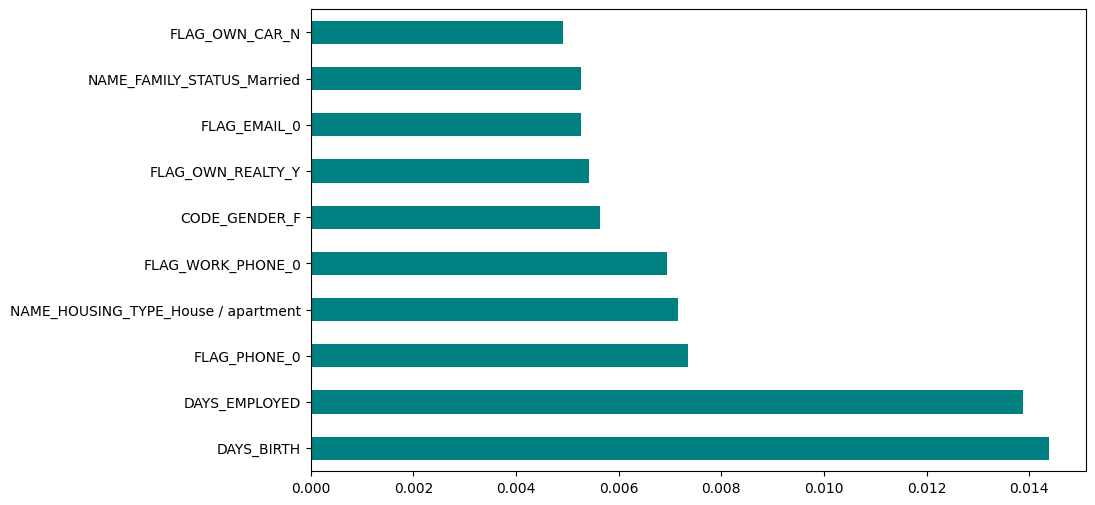

In [4]:
# Feature Selection by Filter method
# Information Gain
importances = mutual_info_classif(X_train_2label, y_train_2label)
feat_importances = pd.Series(importances, X_train_2label.columns)

# Select the top 10 features
top_10_feats = feat_importances.nlargest(10)

plt.figure(figsize=(10, 6))
top_10_feats.plot(kind='barh', color='teal')
plt.show()

In [5]:
# From here, we will use the top 10 features for the Neural Network Model
top_10 = top_10_feats.index.to_list()
print(top_10)

['DAYS_BIRTH', 'DAYS_EMPLOYED', 'FLAG_PHONE_0', 'NAME_HOUSING_TYPE_House / apartment', 'FLAG_WORK_PHONE_0', 'CODE_GENDER_F', 'FLAG_OWN_REALTY_Y', 'FLAG_EMAIL_0', 'NAME_FAMILY_STATUS_Married', 'FLAG_OWN_CAR_N']


In [6]:
# Select only the top 10 features
X_train_2label_top_10 = X_train_2label.loc[:, top_10]
X_train_3label_top_10 = X_train_3label.loc[:, top_10]

X_test_2label_top_10 = X_test_2label.loc[:, top_10]
X_test_3label_top_10 = X_test_3label.loc[:, top_10]

In [7]:
# Checking shapes to make sure everything fits
# X_train.info() 10 cols
X_train_2label_top_10.shape,X_test_2label_top_10.shape,y_train_2label.shape,y_test_2label.shape

((29245, 10), (7212, 10), (29245,), (7212,))

In [8]:
# We will then test by 2 / 3 labels
# Starting with 2 labels
# Label encoding y_train and y_test

le = LabelEncoder()
le.fit(y_train_2label)
y_train_encoded = le.transform(y_train_2label)
y_test_encoded = le.transform(y_test_2label)

In [9]:
# Set random seed
tf.random.set_seed(0)

# 1. Create the model using the Sequential API
# Input Layer: number of features
# For hidden layer: the number of neurons should be in between the input data dimension and the output data dimension.
# Last layer: number of classes
# model = keras.Sequential([layers.Dense(10, activation='relu'),
#                           layers.Dense(6, activation='relu'),
#                           layers.Dense(1, activation='sigmoid')])
model = tf.keras.Sequential([tf.keras.layers.Dense(10, activation='relu'), # probably need to use this for tensorflow V2.13 above 
                          tf.keras.layers.Dense(6, activation='relu'),
                          tf.keras.layers.Dense(1, activation='sigmoid')])

# 2. Compile the model
model.compile(loss="binary_crossentropy",
              optimizer= "adam",
              metrics=["accuracy"])

# 3. Fit the model
model.fit(X_train_2label_top_10, y_train_encoded, epochs=5)

Epoch 1/5
914/914 [==============================] - 3s 2ms/step - loss: 0.1301 - accuracy: 0.9752
Epoch 2/5
914/914 [==============================] - 1s 2ms/step - loss: 0.1119 - accuracy: 0.9771
Epoch 3/5
914/914 [==============================] - 1s 2ms/step - loss: 0.1107 - accuracy: 0.9771
Epoch 4/5
914/914 [==============================] - 1s 2ms/step - loss: 0.1098 - accuracy: 0.9771
Epoch 5/5
914/914 [==============================] - 1s 2ms/step - loss: 0.1095 - accuracy: 0.9771


In [10]:
# Evaluate Model with test data
score_2label = model.evaluate(x=X_test_2label_top_10, y=y_test_encoded)
print("2-label Test loss:", score_2label[0])
print("2-label Test Accuracy: ", score_2label[1])

226/226 [==============================] - 0s 1ms/step - loss: 0.1158 - accuracy: 0.9753
2-label Test loss: 0.11579608917236328
2-label Test Accuracy:  0.9753189086914062


### Model Evaluation for 2 Labels 

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, precision_recall_curve, f1_score, auc, ConfusionMatrixDisplay

In [32]:
nn_probs = model.predict(X_test_2label_top_10)
print(nn_probs)

  1/226 [..............................] - ETA: 7s

226/226 [==============================] - 0s 1ms/step
[[0.95231104]
 [0.97214377]
 [0.97214377]
 ...
 [0.9807094 ]
 [0.9807094 ]
 [0.9844923 ]]


#### AUC ROC Curve

In [33]:
nn_auc = roc_auc_score(y_test_encoded, nn_probs)
print(f"ROC-AUC score: {round(nn_auc, 3)}")

ROC-AUC score: 0.559


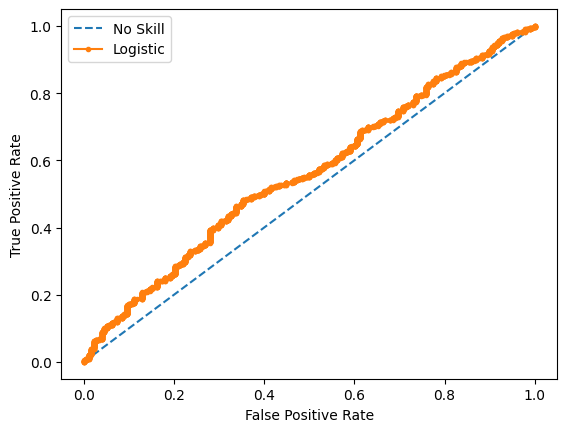

In [34]:
# AUC-ROC Plot 
# Potentially use AUC-ROC curve to determine the threshold and hence create PR curve and confusion matrix

nn_fpr, nn_tpr, thresholds = roc_curve(y_test_encoded, nn_probs)

# to get the no skill line
ns_probs = [0 for _ in range(len(y_test_2label))]
ns_fpr, ns_tpr, _ = roc_curve(y_test_encoded, ns_probs)

#plotting
plt.plot(ns_fpr, ns_tpr, linestyle = '--', label = "No Skill")
plt.plot(nn_fpr, nn_tpr, marker = '.', label = "Logistic")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# model is slightly better than random guessing

In [35]:
# To determine the best threshold using AUC-ROC 
j_statistics = nn_tpr + (1 - nn_fpr) - 1 # making use of Youden's J statistics to determine the threshold, sensitivity + specificity - 1
best_threshold = thresholds[np.argmax(j_statistics)]
print(best_threshold) 

0.9735562


#### Confusion Matrix

In [36]:
y_pred_labels = [1 if proba > best_threshold else 0 for proba in nn_probs] 

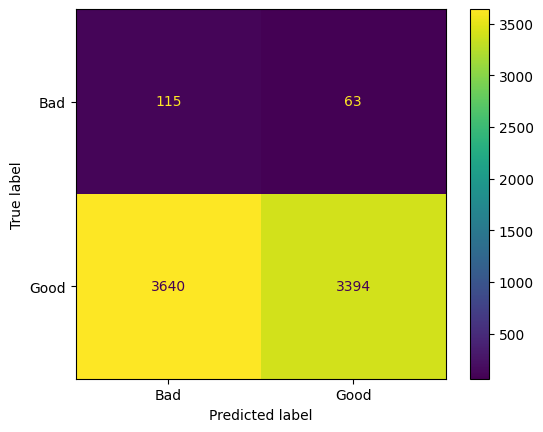

In [37]:
cm = confusion_matrix(y_test_encoded, y_pred_labels)
cm_display_nn = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['Bad', 'Good'])
cm_display_nn.plot()
plt.show()

#### Precision Recall Curve

In [30]:
# Precision recall score 
nn_precision, nn_recall, _ = precision_recall_curve(y_test_encoded, nn_probs)
nn_f1, nn_auc = f1_score(y_test_encoded, y_pred_labels), auc(nn_recall, nn_precision)
print(f"f1-score: {round(nn_f1, 3)}\nauc={round(nn_auc, 3)}")

f1-score: 0.647
auc=0.98


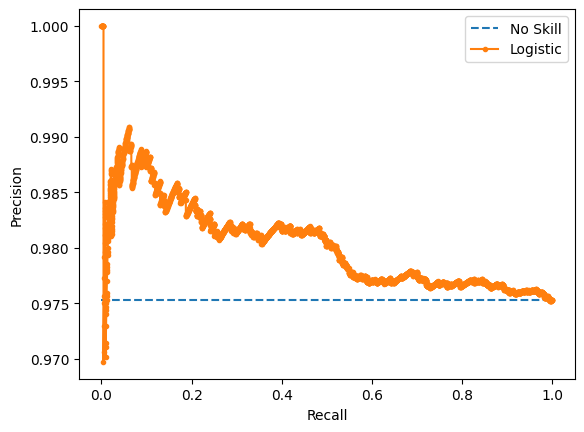

In [25]:
# Precision- Recall curve ???????
no_skill = len(y_test_encoded[y_test_encoded==1])/len(y_test_encoded)
plt.plot([0,1], [no_skill, no_skill], linestyle = '--', label = 'No Skill')
plt.plot(nn_recall, nn_precision, marker = '.', label = "Logistic")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

In [20]:
# Now 3 labels
# Label encoding y_train and y_test

le = LabelEncoder()
le.fit(y_train_3label)
y_train_encoded = le.transform(y_train_3label)
y_test_encoded = le.transform(y_test_3label)

In [21]:
# Set random seed
tf.random.set_seed(0)

# 1. Create the model using the Sequential API
# Input Layer: number of features
# For hidden layer: the number of neurons should be in between the input data dimension and the output data dimension.
# Last layer: number of classes
# sparse categorical crossentropy is appropriate for cases where the classes are mutually exclusive, meaning each sample belongs to only one class.
# model = keras.Sequential([layers.Dense(10, activation='relu'),
#                           layers.Dense(6, activation='relu'),
#                           layers.Dense(3, activation='softmax')])
model = tf.keras.Sequential([tf.keras.layers.Dense(10, activation='relu'), # probably need to use this for tensorflow V2.13 above 
                          tf.keras.layers.Dense(6, activation='relu'),
                          tf.keras.layers.Dense(3, activation='softmax')])

# 2. Compile the model
model.compile(loss="sparse_categorical_crossentropy",
              optimizer= "adam",
              metrics=['sparse_categorical_accuracy'])

# 3. Fit the model
model.fit(X_train_3label_top_10, y_train_encoded, epochs=5)

Epoch 1/5
914/914 [==============================] - 1s 894us/step - loss: 0.4804 - sparse_categorical_accuracy: 0.8677
Epoch 2/5
914/914 [==============================] - 1s 894us/step - loss: 0.4175 - sparse_categorical_accuracy: 0.8849
Epoch 3/5
914/914 [==============================] - 1s 898us/step - loss: 0.4161 - sparse_categorical_accuracy: 0.8849
Epoch 4/5
914/914 [==============================] - 1s 907us/step - loss: 0.4154 - sparse_categorical_accuracy: 0.8849
Epoch 5/5
914/914 [==============================] - 1s 891us/step - loss: 0.4149 - sparse_categorical_accuracy: 0.8849


In [22]:
# Evaluate Model with test data
score_3label = model.evaluate(x=X_test_3label_top_10, y=y_test_encoded)
print("3-label Test loss:", score_3label[0])
print("3-label Test Accuracy: ", score_3label[1])

226/226 [==============================] - 0s 874us/step - loss: 0.4169 - sparse_categorical_accuracy: 0.8853
3-label Test loss: 0.4169202744960785
3-label Test Accuracy:  0.8853300213813782


In [23]:
# In Summary
print("2-label Test loss:", score_2label[0])
print("2-label Test Accuracy: ", score_2label[1])
print("")
print("3-label Test loss:", score_3label[0])
print("3-label Test Accuracy: ", score_3label[1])
# 2 label model performed better

2-label Test loss: 0.1163177564740181
2-label Test Accuracy:  0.9753189086914062

3-label Test loss: 0.4169202744960785
3-label Test Accuracy:  0.8853300213813782


### Model Evaluation for 3 labels 

In [24]:
nn_probs_3labels = model.predict(X_test_3label_top_10)
# output: [[0.03649377 0.8464661  0.11704008]
#          [0.02847519 0.8852421  0.08628272]
#          ......] list of list of probabilities 
nn_pred_labels = [np.argmax(p) for p in nn_probs_3labels]

226/226 [==============================] - 0s 897us/step


#### Confusion Matrix

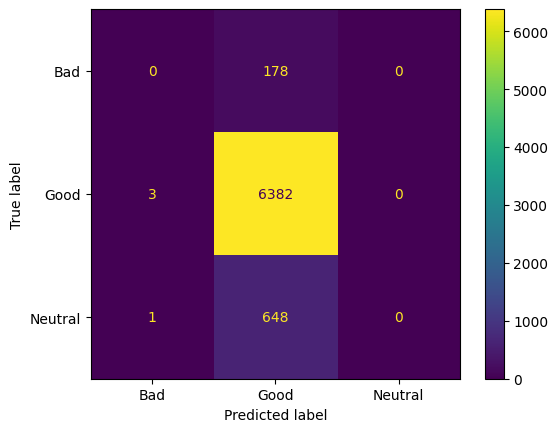

In [25]:
cm = confusion_matrix(y_test_encoded, y_pred_labels)
cm_display_nn3 = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['Bad', 'Good', 'Neutral'])
cm_display_nn3.plot()
plt.show()